# 1. Project Setup: Customer Churn Prediction

---

## Objective:

Predict whether a customer is likely to churn (stop using the service) based on demographic and usage data. This helps the business proactively retain customers.

### Steps:

1.  **Import Libraries:** Load necessary Python packages.
2.  **Load Data & Balance:** Read the dataset and fix the heavy class imbalance.
3.  **Exploratory Data Analysis (EDA) & Cleaning:** Understand the data, visualize distributions, and handle missing values.
4.  **Feature Engineering & Preprocessing:** Select features, encode variables, and scale numerical features.
5.  **Model Training & Evaluation:**
    - Split data into training and testing sets.
    - Train classifiers (Logistic Regression, KNN, SVM, Decision Tree, Random Forest).
    - Tune hyperparameters using GridSearchCV.
6.  **Model Selection & Export:** Choose the best model and save it for the app.


In [1]:
# 1.1 Install & Import Libraries
# !pip install imbalanced-learn

# 1.1 Install & Import Libraries

# --- STEP 1: IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # For saving the model and scaler

# Ensure plots display in Jupyter
%matplotlib inline

# Scikit-learn imports
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Imbalanced-learn import for SMOTE
from imblearn.over_sampling import SMOTE

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# 2. Load & Balance Data

---

Load the dataset and immediately address the 88% vs 12% imbalance by undersampling the majority class.


In [2]:
# 2. Load Data
df = pd.read_csv('customer_churn_data.csv')
print("Dataframe Read Successfully!")

initial_count = len(df)
df = df.drop_duplicates()
new_count = len(df)

if initial_count > new_count:
    print(f"Removed {initial_count - new_count} duplicate rows!")
else:
    print("No duplicates found.")

print("\n--- Original Class Distribution ---")
print(df['Churn'].value_counts())

Dataframe Read Successfully!
No duplicates found.

--- Original Class Distribution ---
Churn
Yes    883
No     117
Name: count, dtype: int64


## 2.1 Initial Data Inspection

Display the first few rows and general information about the DataFrame.


In [3]:
print("\n--- First 5 Rows ---")
display(df.head())  # Display first 5 rows

print("\n--- DataFrame Info ---")
df.info()  # Get column data types and non-null counts


--- First 5 Rows ---


,CustomerID,Age,Gender,Tenure,MonthlyCharges,ContractType,InternetService,TotalCharges,TechSupport,Churn
0,1,49,Male,4,88.35,Month-to-Month,Fiber Optic,353.40,Yes,Yes
1,2,43,Male,0,36.67,Month-to-Month,Fiber Optic,0.00,Yes,Yes
2,3,51,Female,2,63.79,Month-to-Month,Fiber Optic,127.58,No,Yes
3,4,60,Female,8,102.34,One-Year,DSL,818.72,Yes,Yes
4,5,42,Male,32,69.01,Month-to-Month,NaN,2208.32,No,Yes



--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       1000 non-null   int64  
 1   Age              1000 non-null   int64  
 2   Gender           1000 non-null   object 
 3   Tenure           1000 non-null   int64  
 4   MonthlyCharges   1000 non-null   float64
 5   ContractType     1000 non-null   object 
 6   InternetService  703 non-null    object 
 7   TotalCharges     1000 non-null   float64
 8   TechSupport      1000 non-null   object 
 9   Churn            1000 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 78.3+ KB


# 3. Exploratory Data Analysis (EDA) & Cleaning

---

## 3.1 Check for Missing Values


In [4]:
print("--- Missing Values Count ---")
print(df.isnull().sum())

--- Missing Values Count ---
CustomerID           0
Age                  0
Gender               0
Tenure               0
MonthlyCharges       0
ContractType         0
InternetService    297
TotalCharges         0
TechSupport          0
Churn                0
dtype: int64


In [5]:
# Fill NA with 'None'
df['InternetService'] = df['InternetService'].fillna("None")

print("\n--- Missing Values Count After Filling ---")
print(df.isnull().sum())


--- Missing Values Count After Filling ---
CustomerID         0
Age                0
Gender             0
Tenure             0
MonthlyCharges     0
ContractType       0
InternetService    0
TotalCharges       0
TechSupport        0
Churn              0
dtype: int64


## 3.2 Summary Statistics

Get descriptive statistics for numerical and categorical columns.


In [6]:
print("\n--- Numerical Summary ---")
display(df.describe())  # Statistics for numerical columns

print("\n--- Categorical Summary ---")
display(df.describe(include=['object']))  # Statistics for categorical columns


--- Numerical Summary ---


,CustomerID,Age,Tenure,MonthlyCharges,TotalCharges
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,500.500000,44.674000,18.97300,74.391290,1404.364060
std,288.819436,9.797741,18.89257,25.712083,1571.755048
min,1.000000,12.000000,0.00000,30.000000,0.000000
25%,250.750000,38.000000,5.00000,52.357500,345.217500
50%,500.500000,45.000000,13.00000,74.060000,872.870000
75%,750.250000,51.000000,26.00000,96.102500,1900.175000
max,1000.000000,83.000000,122.00000,119.960000,12416.250000



--- Categorical Summary ---


,Gender,ContractType,InternetService,TechSupport,Churn
count,1000,1000,1000,1000,1000
unique,2,3,3,2,2
top,Female,Month-to-Month,Fiber Optic,Yes,Yes
freq,538,511,395,506,883


## 3.3 Data Visualization

Visualize the balanced distribution.


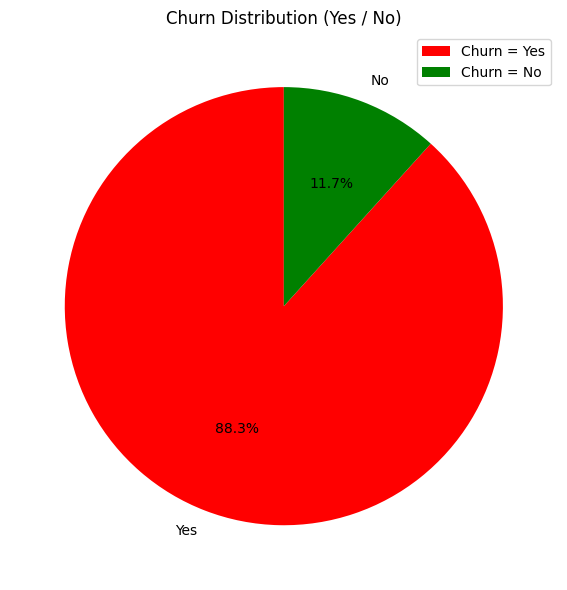

In [7]:
plt.figure(figsize=(6, 6))
# Pie chart for Churn
df['Churn'].value_counts().plot(kind='pie', colors=['red', 'green'],
                                autopct='%1.1f%%', startangle=90)
plt.title('Churn Distribution (Yes / No)')
plt.ylabel("")
plt.legend(['Churn = Yes', 'Churn = No'])
plt.tight_layout()
plt.show()

### 3.3.1 Numerical Feature Distributions

Visualize the distributions of numerical features ('Age', 'Tenure', 'MonthlyCharges').


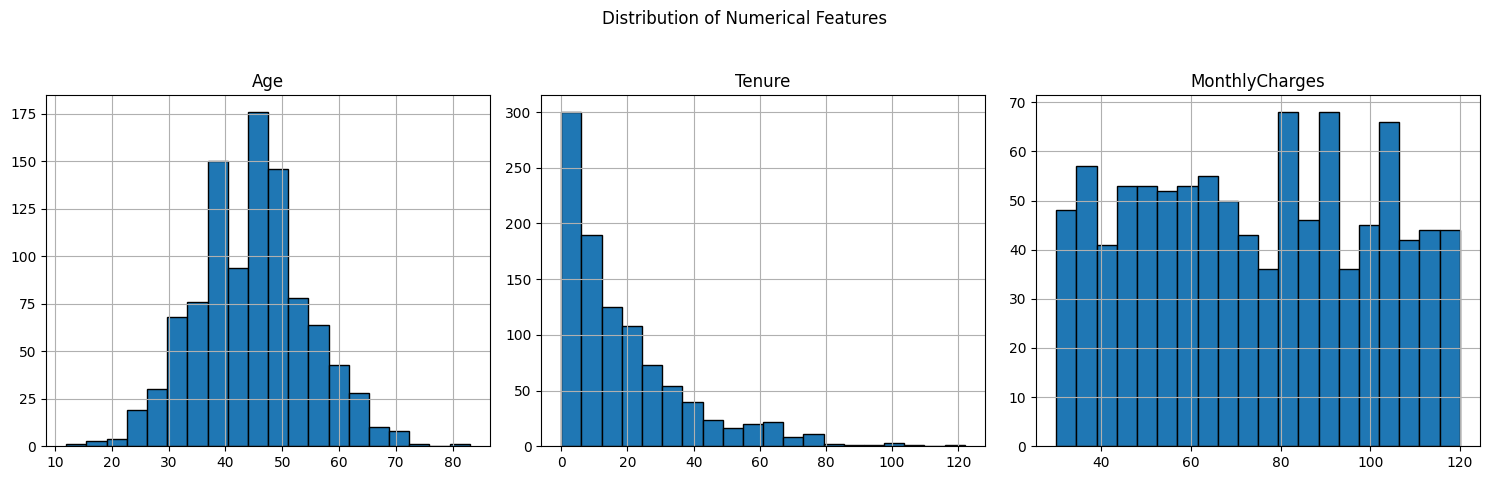

In [8]:
numerical_features = ['Age', 'Tenure', 'MonthlyCharges']
df[numerical_features].hist(bins=20, figsize=(
    15, 5), layout=(1, 3), edgecolor='black')
plt.suptitle('Distribution of Numerical Features')
# Adjust layout to prevent title overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 3.3.2 Categorical Feature Distributions

Visualize the counts for each category in the categorical features.


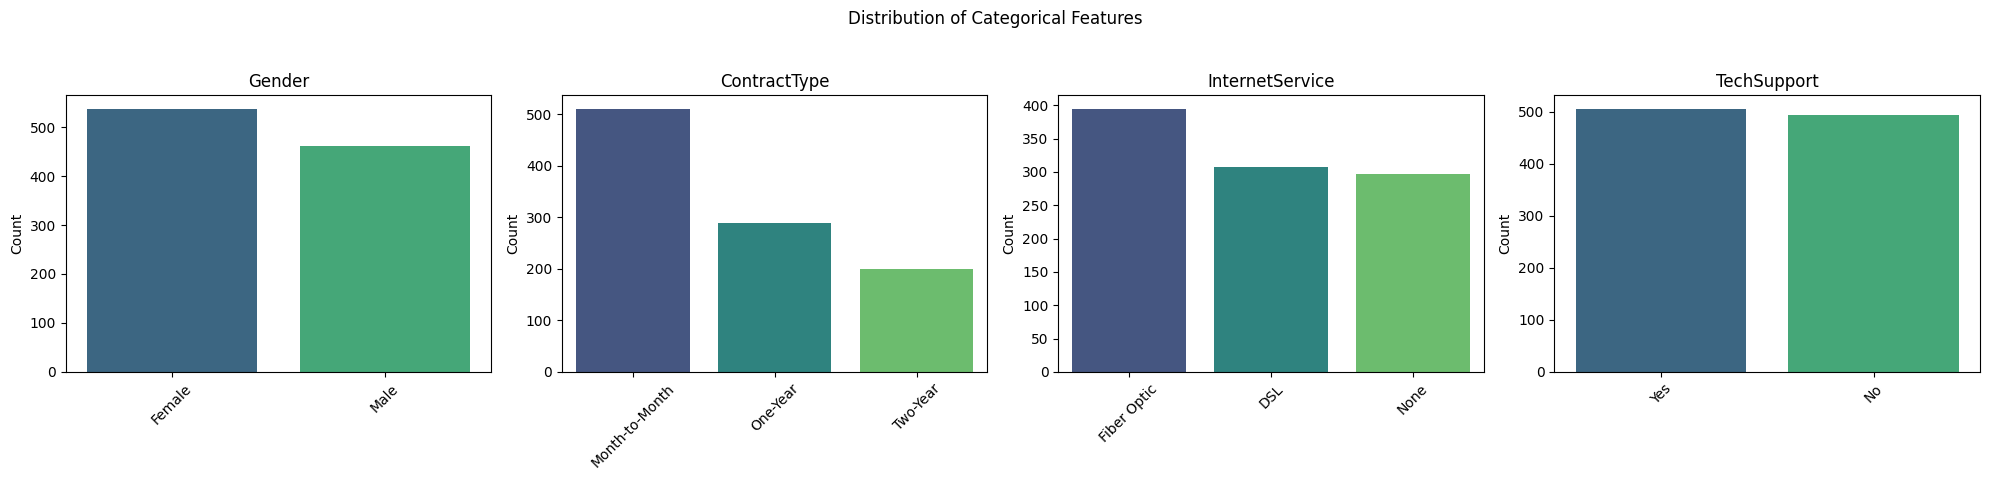

In [9]:
categorical_features = ['Gender', 'ContractType',
                        'InternetService', 'TechSupport']
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Distribution of Categorical Features')

for i, col in enumerate(categorical_features):
    sns.countplot(
        x=col, data=df, ax=axes[i], palette='viridis', order=df[col].value_counts().index)
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 3.3.3 Correlation Analysis (Numerical Features)

Examine the correlation between numerical features. 'Tenure' and 'TotalCharges' show a strong positive correlation (0.89) as expected.


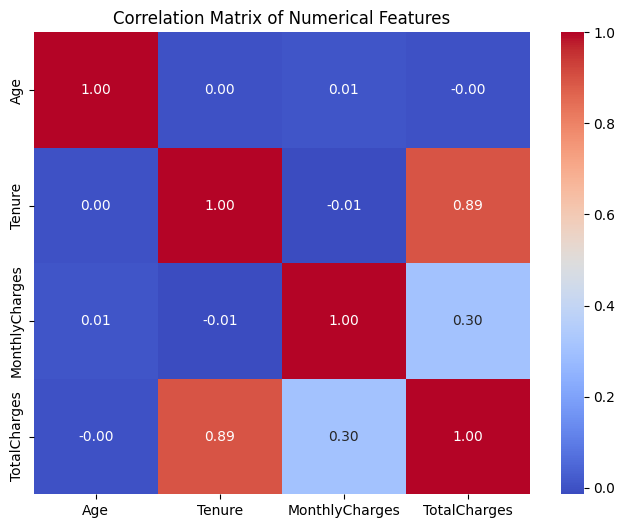

In [10]:
plt.figure(figsize=(8, 6))
# Selecting only numeric columns for correlation - excluding CustomerID as it's just an identifier
numeric_df_for_corr = df[['Age', 'Tenure', 'MonthlyCharges', 'TotalCharges']]
sns.heatmap(numeric_df_for_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

### 3.3.4 Feature Relationships with Churn

Analyze how different features relate to the 'Churn' outcome.


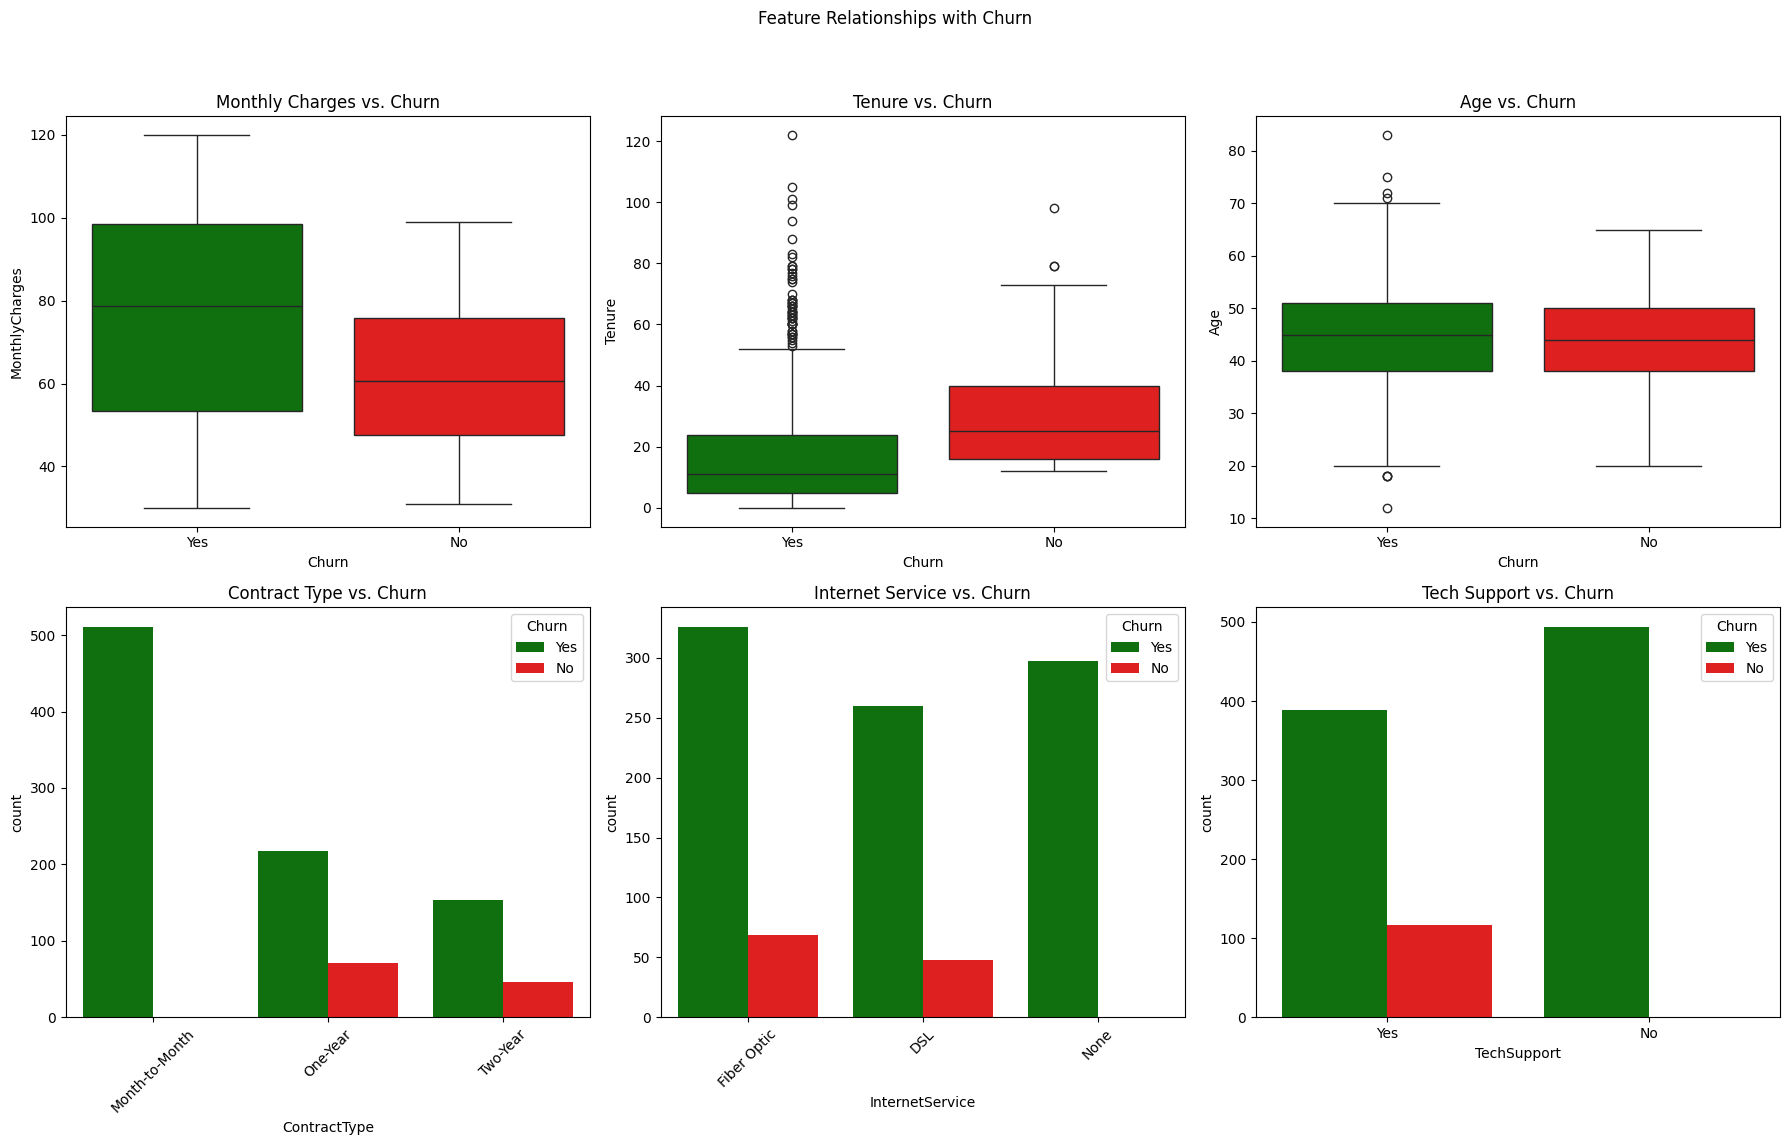

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Feature Relationships with Churn')

# Monthly Charges vs Churn (Box Plot)
sns.boxplot(x='Churn', y='MonthlyCharges', data=df,
            ax=axes[0, 0], palette=['green', 'red'])
axes[0, 0].set_title('Monthly Charges vs. Churn')

# Tenure vs Churn (Box Plot)
sns.boxplot(x='Churn', y='Tenure', data=df,
            ax=axes[0, 1], palette=['green', 'red'])
axes[0, 1].set_title('Tenure vs. Churn')

# Age vs Churn (Box Plot)
sns.boxplot(x='Churn', y='Age', data=df,
            ax=axes[0, 2], palette=['green', 'red'])
axes[0, 2].set_title('Age vs. Churn')

# Contract Type vs Churn (Count Plot)
sns.countplot(x='ContractType', hue='Churn', data=df,
              ax=axes[1, 0], palette=['green', 'red'])
axes[1, 0].set_title('Contract Type vs. Churn')
axes[1, 0].tick_params(axis='x', rotation=45)

# Internet Service vs Churn (Count Plot)
sns.countplot(x='InternetService', hue='Churn', data=df,
              ax=axes[1, 1], palette=['green', 'red'])
axes[1, 1].set_title('Internet Service vs. Churn')
axes[1, 1].tick_params(axis='x', rotation=45)

# Tech Support vs Churn (Count Plot)
sns.countplot(x='TechSupport', hue='Churn', data=df,
              ax=axes[1, 2], palette=['green', 'red'])
axes[1, 2].set_title('Tech Support vs. Churn')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 4. Feature Engineering & Preprocessing

---

## 4.1 Feature Selection


In [12]:
# Selected features and target variable
features = ['Age', 'Gender', 'Tenure', 'MonthlyCharges',
            'InternetService', 'TechSupport']
target = 'Churn'

X = df[features]
y = df[[target]]

## 4.2 Encoding Categorical Features


In [13]:
# 1. Check unique values
print("Unique Contract Types:", df['ContractType'].unique())
print("Unique Internet Service:", df['InternetService'].unique())

# 2. Apply Mappings
X = df[features].copy()

X['Gender'] = X['Gender'].apply(lambda x: 1 if x == 'Female' else 0)

X['InternetService'] = X['InternetService'].map({
    'None': 0,
    'DSL': 1,
    'Fiber Optic': 2
})

X['TechSupport'] = X['TechSupport'].map({'No': 0, 'Yes': 1})

# 3. VERIFY there are no NaNs left
print("\n--- Check for NaNs after encoding ---")
print(X.isnull().sum())

print("\n--- Features (X) after Encoding ---")
display(X.head())

Unique Contract Types: ['Month-to-Month' 'One-Year' 'Two-Year']
Unique Internet Service: ['Fiber Optic' 'DSL' 'None']

--- Check for NaNs after encoding ---
Age                0
Gender             0
Tenure             0
MonthlyCharges     0
InternetService    0
TechSupport        0
dtype: int64

--- Features (X) after Encoding ---


,Age,Gender,Tenure,MonthlyCharges,InternetService,TechSupport
0,49,0,4,88.35,2,1
1,43,0,0,36.67,2,1
2,51,1,2,63.79,2,0
3,60,1,8,102.34,1,1
4,42,0,32,69.01,0,0


## 4.3 Encoding Target Variable


In [14]:
y['Churn'] = y['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
print("\n--- Target (y) after Churn Encoding ---")
display(y.head())


--- Target (y) after Churn Encoding ---


,Churn
0,1
1,1
2,1
3,1
4,1


## 4.4 Data Splitting


In [15]:
# 1. Split the data FIRST to prevent data leakage
# We keep the test set as a true representation of reality (Imbalanced)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"Original Training Set Shape: {X_train.shape}")
print(f"Test Set Shape: {X_test.shape}")

# 2. Apply SMOTE to Balance the Training Set ONLY
print("\n--- Applying SMOTE to Training Set ---")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Update X_train and y_train to use the balanced data
X_train = X_train_resampled
y_train = y_train_resampled

print(f"New Balanced Training Set Shape: {X_train.shape}")
print("New Class Distribution in Training:")
print(y_train.value_counts())

Original Training Set Shape: (800, 6)
Test Set Shape: (200, 6)

--- Applying SMOTE to Training Set ---
New Balanced Training Set Shape: (1412, 6)
New Class Distribution in Training:
Churn
0        706
1        706
Name: count, dtype: int64


## 4.5 Feature Scaling


In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Export the fitted scaler
joblib.dump(scaler, 'scaler.pkl')
print("\nScaler saved as 'scaler.pkl'")


Scaler saved as 'scaler.pkl'


# 5. Model Training & Evaluation

---

## 5.1 Evaluation Function


In [17]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """Prints accuracy and classification report."""
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    print(f"--- {model_name} Evaluation ---")
    print(f"Accuracy Score: {accuracy:.4f}")
    print("Classification Report:")
    print(report)

## 5.2 Logistic Regression


In [18]:
logistic_regression = LogisticRegression(random_state=42)
logistic_regression.fit(X_train_scaled, y_train)
y_pred_lr_smote = logistic_regression.predict(X_test_scaled)
evaluate_model(y_test, y_pred_lr_smote, "Logistic Regression")

--- Logistic Regression Evaluation ---
Accuracy Score: 0.8450
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.87      0.56        23
           1       0.98      0.84      0.91       177

    accuracy                           0.84       200
   macro avg       0.70      0.86      0.73       200
weighted avg       0.92      0.84      0.87       200



## 5.3 K-Nearest Neighbors (KNN)


In [19]:
param_grid_kn = {
    'n_neighbors': [3, 5, 7, 9, 13, 15],
    'weights': ['uniform', 'distance']
}
grid_kn_smote = GridSearchCV(KNeighborsClassifier(), param_grid_kn, cv=5)
grid_kn_smote.fit(X_train_scaled, y_train)

print(f"\nBest KNN Params: {grid_kn_smote.best_params_}")
y_pred_kn_smote = grid_kn_smote.predict(X_test_scaled)
evaluate_model(y_test, y_pred_kn_smote, "KNN")


Best KNN Params: {'n_neighbors': 3, 'weights': 'distance'}
--- KNN Evaluation ---
Accuracy Score: 0.8850
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.61      0.55        23
           1       0.95      0.92      0.93       177

    accuracy                           0.89       200
   macro avg       0.72      0.76      0.74       200
weighted avg       0.90      0.89      0.89       200



## 5.4 Support Vector Machine (SVM)


In [20]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}
svm_smote = SVC(random_state=42)
grid_svc_smote = GridSearchCV(svm_smote, param_grid_svm, cv=5)
grid_svc_smote.fit(X_train_scaled, y_train)

print(f"\nBest SVM Params: {grid_svc_smote.best_params_}")
y_pred_svc_smote = grid_svc_smote.predict(X_test_scaled)
evaluate_model(y_test, y_pred_svc_smote, "SVM")


Best SVM Params: {'C': 10, 'kernel': 'rbf'}
--- SVM Evaluation ---
Accuracy Score: 0.8950
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.83      0.64        23
           1       0.98      0.90      0.94       177

    accuracy                           0.90       200
   macro avg       0.75      0.87      0.79       200
weighted avg       0.92      0.90      0.90       200



## 5.5 Random Forest Classifier


In [21]:
param_grid_rfc = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20]
}

rfc = RandomForestClassifier(random_state=42)
grid_rfc = GridSearchCV(rfc, param_grid_rfc, cv=5)
grid_rfc.fit(X_train_scaled, y_train)

print(f"\nBest Random Forest Params: {grid_rfc.best_params_}")

# 1. Standard Prediction
y_pred_rfc = grid_rfc.predict(X_test_scaled)
evaluate_model(y_test, y_pred_rfc, "Random Forest")

# 2.Cross-Validation Sanity Check
# This checks if the model is overfitting or if the 100% is a fluke
cv_scores = cross_val_score(
    grid_rfc.best_estimator_, X_train_scaled, y_train, cv=5, scoring='accuracy')

print(f"\n--- Cross-Validation Sanity Check (5 Folds) ---")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Scores per fold: {cv_scores}")


Best Random Forest Params: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
--- Random Forest Evaluation ---
Accuracy Score: 0.8950
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.78      0.63        23
           1       0.97      0.91      0.94       177

    accuracy                           0.90       200
   macro avg       0.75      0.85      0.79       200
weighted avg       0.92      0.90      0.90       200


--- Cross-Validation Sanity Check (5 Folds) ---
Mean Accuracy: 0.9504
Scores per fold: [0.96113074 0.93992933 0.94326241 0.95035461 0.95744681]


# 6. Model Selection & Export


In [22]:
# Select the best performing model
best_model = grid_rfc.best_estimator_
print("\n--- Best Model Selected ---")
print(best_model)

# Exporting the best model
joblib.dump(best_model, 'model.pkl')
print("\nBest model saved as 'model.pkl'")

# Feature Order for Prediction
print("\nFeature Order for Prediction:", list(X.columns))


--- Best Model Selected ---
RandomForestClassifier(n_estimators=200, random_state=42)

Best model saved as 'model.pkl'

Feature Order for Prediction: ['Age', 'Gender', 'Tenure', 'MonthlyCharges', 'InternetService', 'TechSupport']
